```{margin} Adaptation!
This work was adapted and simplified from one of the Materials Project workshop lessons, available at https://github.com/materialsproject/workshop/, available under the BSD-3-clause license. As such, this notebook is available under the BSD-3-clause license. 
```

`````{note}
This lecture is going to:
* Discuss why and how we can generate descriptors for materials problems
* Introduce several descriptors/features that can be used for:
    * chemical compositions
    * structure (atomic xyz structure) features
    * ...
* Demonstrate one package for generating features (`matminer`)
* Fit a simple linear model to a material science dataset 
`````

# Featurizing molecules and materials for chemical engineering

We've done a lot of work with polynomial features so far, but chemical engineering is full of examples where it's not clear exactly what the right features are. In this lecture we'll talk about how to turn data like chemical composition or atomic structures into features that can be used with common machine learning models that expect feature vectors (like our sklearn models). 

`````{seealso}
[Google slides on various featurization strategies in molecules, materials, and catalysis!](https://docs.google.com/presentation/d/11cNUIWjqhxwYdVfmkkNXCac-rks7ZkrN9VgiIis6VhQ/edit#slide=id.g9b4bd6acd3_0_6)
`````

## Demonstration: Materials features using matminer


A material science workflow looks very similar to the ones we've done so far, but the starting point is different!
1. Take raw inputs, such as a list of compositions, and an associated target property to learn.
2. Convert the raw inputs into *descriptors* or *features* that can be learned by machine learning algorithms.
3. Train a machine learning model on the data.
4. Plot and analyze the performance of the model.

![machine learning workflow](resources/ml_workflow.png)

There are many python packages available to featurize materials or molecules. The `matminer` package has been developed to help make machine learning of materials properties easy and hassle free. The aim of matminer is to connect materials data with data mining algorithms and data visualization.

`````{seealso}
Many more tutorials on how to use matminer (beyond the scope of this example) are available in the `matminer_examples` repository, available [here](https://github.com/hackingmaterials/matminer_examples).
`````


## Example materials science dataset (computational dielectric properties of inorganic crystals)

Matminer interfaces with many materials databases,  including:
- Materials Project
- Citrine
- AFLOW
- Materials Data Facility (MDF)
- Materials Platform for Data Science (MPDS)

In addition, it also includes datasets from published literature. Matminer hosts a repository of ~45 datasets which comes from published and peer-reviewed machine learning investigations of materials properties or publications of high-throughput computing studies. 

A list of the literature-based datasets can be printed using the `get_available_datasets()` function. This also prints information about what the dataset contains, such as the number of samples, the target properties, and how the data was obtained (e.g., via theory or experiment).

`````{seealso}
More information on accessing other materials databases are detailed in the [matminer_examples](https://github.com/hackingmaterials/matminer_examples) repository.
`````



### Loading the dielectric dataset

All datasets can be loaded using the `load_dataset()` function and the database name. To save installation space, the datasets are not automatically downloaded when matminer is installed. Instead, the first time the dataset is loaded, it will be downloaded from the internet and stored in the matminer installation directory.

Let's say we're interested in the `dielectric_constant` dataset,  which contains 1,056 structures with dielectric properties calculated with DFPT-PBE. We can download it with the `load_dataset` function.

We'll set an environment variable `MATMINER_DATA` which will tell matminer to download all our dataset to a directory `./data`. If you are running this locally, you usually don't need to set this variable as matminer will download the dataset directly to your matminer source code folder.



In [36]:
# Load the dielectric dataset
from matminer.datasets import load_dataset

df = load_dataset("dielectric_constant")

In [39]:
?matmin

Object `matminer.datasets` not found.


We can get some more detailed information about this dataset using the `get_all_dataset_info(<dataset>)` function from matminer.

In [38]:
from matminer.datasets import get_all_dataset_info

print(get_all_dataset_info("dielectric_constant"))

Dataset: dielectric_constant
Description: 1,056 structures with dielectric properties, calculated with DFPT-PBE.
Columns:
	band_gap: Measure of the conductivity of a material
	cif: optional: Description string for structure
	e_electronic: electronic contribution to dielectric tensor
	e_total: Total dielectric tensor incorporating both electronic and ionic contributions
	formula: Chemical formula of the material
	material_id: Materials Project ID of the material
	meta: optional, metadata descriptor of the datapoint
	n: Refractive Index
	nsites: The \# of atoms in the unit cell of the calculation.
	poly_electronic: the average of the eigenvalues of the electronic contribution to the dielectric tensor
	poly_total: the average of the eigenvalues of the total (electronic and ionic) contributions to the dielectric tensor
	poscar: optional: Poscar metadata
	pot_ferroelectric: Whether the material is potentially ferroelectric
	space_group: Integer specifying the crystallographic structure of t

### (Recap of pandas) Manipulating and examining pandas `DataFrame` objects

The datasets are made available as pandas `DataFrame` objects.

The `head()` function prints a summary of the first few rows of a data set. You can scroll across to see more columns. From this, it is easy to see the types of data available in in the dataset.

In [3]:
df.head()

,material_id,formula,nsites,space_group,volume,structure,band_gap,e_electronic,e_total,n,poly_electronic,poly_total,pot_ferroelectric,cif,meta,poscar
0,mp-441,Rb2Te,3,225,159.501208,"[[1.75725875 1.2425695 3.04366125] Rb, [5.271...",1.88,"[[3.44115795, -3.097e-05, -6.276e-05], [-2.837...","[[6.23414745, -0.00035252, -9.796e-05], [-0.00...",1.86,3.44,6.23,False,#\#CIF1.1\n###################################...,{u'incar': u'NELM = 100\nIBRION = 8\nLWAVE = F...,Rb2 Te1\n1.0\n5.271776 0.000000 3.043661\n1.75...
1,mp-22881,CdCl2,3,166,84.298097,"[[0. 0. 0.] Cd, [ 4.27210959 2.64061969 13.13...",3.52,"[[3.34688382, -0.04498543, -0.22379197], [-0.0...","[[7.97018673, -0.29423886, -1.463590159999999]...",1.78,3.16,6.73,False,#\#CIF1.1\n###################################...,{u'incar': u'NELM = 100\nIBRION = 8\nLWAVE = F...,Cd1 Cl2\n1.0\n3.850977 0.072671 5.494462\n1.78...
2,mp-28013,MnI2,3,164,108.335875,"[[0. 0. 0.] Mn, [-2.07904300e-06 2.40067320e+...",1.17,"[[5.5430849, -5.28e-06, -2.5030000000000003e-0...","[[13.80606079, 0.0006911900000000001, 9.655e-0...",2.23,4.97,10.64,False,#\#CIF1.1\n###################################...,{u'incar': u'NELM = 100\nIBRION = 8\nLWAVE = F...,Mn1 I2\n1.0\n4.158086 0.000000 0.000000\n-2.07...
3,mp-567290,LaN,4,186,88.162562,[[-1.73309900e-06 2.38611186e+00 5.95256328e...,1.12,"[[7.09316738, 7.99e-06, -0.0003864700000000000...","[[16.79535386, 8.199999999999997e-07, -0.00948...",2.65,7.04,17.99,False,#\#CIF1.1\n###################################...,{u'incar': u'NELM = 100\nIBRION = 8\nLWAVE = F...,La2 N2\n1.0\n4.132865 0.000000 0.000000\n-2.06...
4,mp-560902,MnF2,6,136,82.826401,"[[1.677294 2.484476 2.484476] Mn, [0. 0. 0.] M...",2.87,"[[2.4239622, 7.452000000000001e-05, 6.06100000...","[[6.44055613, 0.0020446600000000002, 0.0013203...",1.53,2.35,7.12,False,#\#CIF1.1\n###################################...,{u'incar': u'NELM = 100\nIBRION = 8\nLDAUTYPE ...,Mn2 F4\n1.0\n3.354588 0.000000 0.000000\n0.000...


Sometimes, if a dataset is very large, you will be unable to see all the available columns. Instead, you can see the full list of columns using the `columns` attribute:

In [4]:
df.columns

Index(['material_id', 'formula', 'nsites', 'space_group', 'volume',
       'structure', 'band_gap', 'e_electronic', 'e_total', 'n',
       'poly_electronic', 'poly_total', 'pot_ferroelectric', 'cif', 'meta',
       'poscar'],
      dtype='object')

A pandas `DataFrame` includes a function called `describe()` that helps determine statistics for the various numerical/categorical columns in the data. Note that the `describe()` function only describes numerical columns by default.

Sometimes, the `describe()` function will reveal outliers that indicate mistakes in the data.

In [5]:
df.describe()

,nsites,space_group,volume,band_gap,n,poly_electronic,poly_total
count,1056.000000,1056.000000,1056.000000,1056.000000,1056.000000,1056.000000,1056.000000
mean,7.530303,142.970644,166.420376,2.119432,2.434886,7.248049,14.777898
std,3.388443,67.264591,97.425084,1.604924,1.148849,13.054947,19.435303
min,2.000000,1.000000,13.980548,0.110000,1.280000,1.630000,2.080000
25%,5.000000,82.000000,96.262337,0.890000,1.770000,3.130000,7.557500
50%,8.000000,163.000000,145.944691,1.730000,2.190000,4.790000,10.540000
75%,9.000000,194.000000,212.106405,2.885000,2.730000,7.440000,15.482500
max,20.000000,229.000000,597.341134,8.320000,16.030000,256.840000,277.780000


#### Indexing the dataset

We can access a particular column of `DataFrame` by indexing the object using the column name. For example:

In [6]:
df["band_gap"]

0       1.88
1       3.52
2       1.17
3       1.12
4       2.87
        ... 
1051    0.87
1052    3.60
1053    0.14
1054    0.21
1055    0.26
Name: band_gap, Length: 1056, dtype: float64

You can also access multiple columns by indexing with a list of column names rather than a single column name:

Alternatively, we can access a particular row of a `Dataframe` using the `iloc` attribute.

In [7]:
df.iloc[100]

material_id                                                    mp-7140
formula                                                            SiC
nsites                                                               4
space_group                                                        186
volume                                                       42.005504
structure            [[-1.87933700e-06  1.78517223e+00  2.53458835e...
band_gap                                                           2.3
e_electronic         [[6.9589498, -3.29e-06, 0.0014472600000000001]...
e_total              [[10.193825310000001, -3.7090000000000006e-05,...
n                                                                 2.66
poly_electronic                                                   7.08
poly_total                                                       10.58
pot_ferroelectric                                                False
cif                  #\#CIF1.1\n###################################...
meta  

#### Filtering the dataset

Pandas `DataFrame` objects make it very easy to filter the data based on a specific column. We can use the typical Python comparison operators (==, >, >=, <, etc) to filter numerical values. For example, let's find all entries where the cell volume is greater than 580. We do this by filtering on the `volume` column.

Note that we first produce a *boolean mask* – a series of `True` and `False` depending on the comparison. We can then use the mask to filter the `DataFrame`. 

In [8]:
mask = df["volume"] >= 580
df[mask]

,material_id,formula,nsites,space_group,volume,structure,band_gap,e_electronic,e_total,n,poly_electronic,poly_total,pot_ferroelectric,cif,meta,poscar
206,mp-23280,AsCl3,16,19,582.085309,"[[0.13113333 7.14863883 9.63476955] As, [2.457...",3.99,"[[2.2839161900000002, 0.00014519, -2.238000000...","[[2.49739759, 0.00069379, 0.00075864], [0.0004...",1.57,2.47,3.30,False,#\#CIF1.1\n###################################...,{u'incar': u'NELM = 100\nIBRION = 8\nLWAVE = F...,As4 Cl12\n1.0\n4.652758 0.000000 0.000000\n0.0...
216,mp-9064,RbTe,12,189,590.136085,"[[6.61780282 0. 0. ] Rb, [1.750...",0.43,"[[3.25648277, 5.9650000000000007e-05, 1.57e-06...","[[5.34517928, 0.00022474000000000002, -0.00018...",2.05,4.20,6.77,False,#\#CIF1.1\n###################################...,{u'incar': u'NELM = 100\nIBRION = 8\nLWAVE = F...,Rb6 Te6\n1.0\n10.118717 0.000000 0.000000\n-5....
219,mp-23230,PCl3,16,62,590.637274,"[[6.02561815 8.74038483 7.55586375] P, [2.7640...",4.03,"[[2.39067769, 0.00017593, 8.931000000000001e-0...","[[2.80467218, 0.00034093000000000003, 0.000692...",1.52,2.31,2.76,False,#\#CIF1.1\n###################################...,{u'incar': u'NELM = 100\nIBRION = 8\nLWAVE = F...,P4 Cl12\n1.0\n6.523152 0.000000 0.000000\n0.00...
251,mp-2160,Sb2Se3,20,62,597.341134,"[[3.02245275 0.42059268 1.7670481 ] Sb, [ 1.00...",0.76,"[[19.1521058, 5.5e-06, 0.00025268], [-1.078000...","[[81.93819038000001, 0.0006755800000000001, 0....",3.97,15.76,63.53,True,#\#CIF1.1\n###################################...,{u'incar': u'NELM = 100\nIBRION = 8\nLWAVE = F...,Sb8 Se12\n1.0\n4.029937 0.000000 0.000000\n0.0...


We can use this method of filtering to clean our dataset. For example, if we only wanted our dataset to only include nonmetals (materials with a non-zero band gap), we can do this easily by filtering the `band_gap` column.

In [9]:
mask = df["band_gap"] > 0
nonmetal_df = df[mask]
nonmetal_df

,material_id,formula,nsites,space_group,volume,structure,band_gap,e_electronic,e_total,n,poly_electronic,poly_total,pot_ferroelectric,cif,meta,poscar
0,mp-441,Rb2Te,3,225,159.501208,"[[1.75725875 1.2425695 3.04366125] Rb, [5.271...",1.88,"[[3.44115795, -3.097e-05, -6.276e-05], [-2.837...","[[6.23414745, -0.00035252, -9.796e-05], [-0.00...",1.86,3.44,6.23,False,#\#CIF1.1\n###################################...,{u'incar': u'NELM = 100\nIBRION = 8\nLWAVE = F...,Rb2 Te1\n1.0\n5.271776 0.000000 3.043661\n1.75...
1,mp-22881,CdCl2,3,166,84.298097,"[[0. 0. 0.] Cd, [ 4.27210959 2.64061969 13.13...",3.52,"[[3.34688382, -0.04498543, -0.22379197], [-0.0...","[[7.97018673, -0.29423886, -1.463590159999999]...",1.78,3.16,6.73,False,#\#CIF1.1\n###################################...,{u'incar': u'NELM = 100\nIBRION = 8\nLWAVE = F...,Cd1 Cl2\n1.0\n3.850977 0.072671 5.494462\n1.78...
2,mp-28013,MnI2,3,164,108.335875,"[[0. 0. 0.] Mn, [-2.07904300e-06 2.40067320e+...",1.17,"[[5.5430849, -5.28e-06, -2.5030000000000003e-0...","[[13.80606079, 0.0006911900000000001, 9.655e-0...",2.23,4.97,10.64,False,#\#CIF1.1\n###################################...,{u'incar': u'NELM = 100\nIBRION = 8\nLWAVE = F...,Mn1 I2\n1.0\n4.158086 0.000000 0.000000\n-2.07...
3,mp-567290,LaN,4,186,88.162562,[[-1.73309900e-06 2.38611186e+00 5.95256328e...,1.12,"[[7.09316738, 7.99e-06, -0.0003864700000000000...","[[16.79535386, 8.199999999999997e-07, -0.00948...",2.65,7.04,17.99,False,#\#CIF1.1\n###################################...,{u'incar': u'NELM = 100\nIBRION = 8\nLWAVE = F...,La2 N2\n1.0\n4.132865 0.000000 0.000000\n-2.06...
4,mp-560902,MnF2,6,136,82.826401,"[[1.677294 2.484476 2.484476] Mn, [0. 0. 0.] M...",2.87,"[[2.4239622, 7.452000000000001e-05, 6.06100000...","[[6.44055613, 0.0020446600000000002, 0.0013203...",1.53,2.35,7.12,False,#\#CIF1.1\n###################################...,{u'incar': u'NELM = 100\nIBRION = 8\nLDAUTYPE ...,Mn2 F4\n1.0\n3.354588 0.000000 0.000000\n0.000...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1051,mp-568032,Cd(InSe2)2,7,111,212.493121,"[[0. 0. 0.] Cd, [2.9560375 0. 3.03973 ...",0.87,"[[7.74896783, 0.0, 0.0], [0.0, 7.74896783, 0.0...","[[11.85159471, 1e-08, 0.0], [1e-08, 11.8515962...",2.77,7.67,11.76,True,#\#CIF1.1\n###################################...,{u'incar': u'NELM = 100\nIBRION = 8\nLWAVE = F...,Cd1 In2 Se4\n1.0\n5.912075 0.000000 0.000000\n...
1052,mp-696944,LaHBr2,8,194,220.041363,"[[2.068917 3.58317965 3.70992025] La, [4.400...",3.60,"[[4.40504391, 6.1e-07, 0.0], [6.1e-07, 4.40501...","[[8.77136355, 1.649999999999999e-06, 0.0], [1....",2.00,3.99,7.08,True,#\#CIF1.1\n###################################...,{u'incar': u'NELM = 100\nIBRION = 8\nLWAVE = F...,La2 H2 Br4\n1.0\n4.137833 0.000000 0.000000\n-...
1053,mp-16238,Li2AgSb,4,216,73.882306,"[[1.35965225 0.96141925 2.354987 ] Li, [2.719...",0.14,"[[212.60750153, -1.843e-05, 0.0], [-1.843e-05,...","[[232.59707383, -0.0005407400000000001, 0.0025...",14.58,212.61,232.60,True,#\#CIF1.1\n###################################...,{u'incar': u'NELM = 100\nIBRION = 8\nLWAVE = F...,Li2 Ag1 Sb1\n1.0\n4.078957 0.000000 2.354987\n...
1054,mp-4405,Rb3AuO,5,221,177.269065,"[[0. 2.808758 2.808758] Rb, [2.808758 2....",0.21,"[[6.40511712, 0.0, 0.0], [0.0, 6.40511712, 0.0...","[[22.43799785, 0.0, 0.0], [0.0, 22.4380185, 0....",2.53,6.41,22.44,True,#\#CIF1.1\n###################################...,{u'incar': u'NELM = 100\nIBRION = 8\nLWAVE = F...,Rb3 Au1 O1\n1.0\n5.617516 0.000000 0.000000\n0...


Often, a dataset contains many additional columns that are not necessary for machine learning. Before we can train a model on the data, we need to remove any extraneous columns. We can remove whole columns from the dataset using the `drop()` function. This function can be used to drop both rows and columns.

The function takes a list of items to drop. For columns, this is column names whereas for rows it is the row number. Finally, the `axis` option specifies whether the data to drop is columns (`1`) or rows (`0`).

For example, to remove the `nsites`, `space_group`, `e_electronic`, and `e_total` columns, we can run: 

In [10]:
cleaned_df = df.drop(["nsites", "space_group", "e_electronic", "e_total"], axis=1)

Let's examine the cleaned `DataFrame` to see that the columns have been removed.

In [11]:
cleaned_df.head()

,material_id,formula,volume,structure,band_gap,n,poly_electronic,poly_total,pot_ferroelectric,cif,meta,poscar
0,mp-441,Rb2Te,159.501208,"[[1.75725875 1.2425695 3.04366125] Rb, [5.271...",1.88,1.86,3.44,6.23,False,#\#CIF1.1\n###################################...,{u'incar': u'NELM = 100\nIBRION = 8\nLWAVE = F...,Rb2 Te1\n1.0\n5.271776 0.000000 3.043661\n1.75...
1,mp-22881,CdCl2,84.298097,"[[0. 0. 0.] Cd, [ 4.27210959 2.64061969 13.13...",3.52,1.78,3.16,6.73,False,#\#CIF1.1\n###################################...,{u'incar': u'NELM = 100\nIBRION = 8\nLWAVE = F...,Cd1 Cl2\n1.0\n3.850977 0.072671 5.494462\n1.78...
2,mp-28013,MnI2,108.335875,"[[0. 0. 0.] Mn, [-2.07904300e-06 2.40067320e+...",1.17,2.23,4.97,10.64,False,#\#CIF1.1\n###################################...,{u'incar': u'NELM = 100\nIBRION = 8\nLWAVE = F...,Mn1 I2\n1.0\n4.158086 0.000000 0.000000\n-2.07...
3,mp-567290,LaN,88.162562,[[-1.73309900e-06 2.38611186e+00 5.95256328e...,1.12,2.65,7.04,17.99,False,#\#CIF1.1\n###################################...,{u'incar': u'NELM = 100\nIBRION = 8\nLWAVE = F...,La2 N2\n1.0\n4.132865 0.000000 0.000000\n-2.06...
4,mp-560902,MnF2,82.826401,"[[1.677294 2.484476 2.484476] Mn, [0. 0. 0.] M...",2.87,1.53,2.35,7.12,False,#\#CIF1.1\n###################################...,{u'incar': u'NELM = 100\nIBRION = 8\nLDAUTYPE ...,Mn2 F4\n1.0\n3.354588 0.000000 0.000000\n0.000...


You can alternatively *select* multiple columns by passing in a list of column names as an index.

For example, if we're only interested in the `band_gap` and `structure` columns, we can index with `["band_gap", "structure"]`

In [12]:
df[["band_gap", "structure"]]

,band_gap,structure
0,1.88,"[[1.75725875 1.2425695 3.04366125] Rb, [5.271..."
1,3.52,"[[0. 0. 0.] Cd, [ 4.27210959 2.64061969 13.13..."
2,1.17,"[[0. 0. 0.] Mn, [-2.07904300e-06 2.40067320e+..."
3,1.12,[[-1.73309900e-06 2.38611186e+00 5.95256328e...
4,2.87,"[[1.677294 2.484476 2.484476] Mn, [0. 0. 0.] M..."
...,...,...
1051,0.87,"[[0. 0. 0.] Cd, [2.9560375 0. 3.03973 ..."
1052,3.60,"[[2.068917 3.58317965 3.70992025] La, [4.400..."
1053,0.14,"[[1.35965225 0.96141925 2.354987 ] Li, [2.719..."
1054,0.21,"[[0. 2.808758 2.808758] Rb, [2.808758 2...."


## Generating descriptors for machine learning using matminer

In this section, we will learn a bit about how to generate machine-learning descriptors from materials objects in pymatgen. First, we'll generate some descriptors with matminer's "featurizers" classes. Next, we'll use some of what we learned about dataframes in the previous section to examine our descriptors and prepare them for input to machine learning models.

![featurizers_overview.png](resources/featurizers_overview.png)

### Featurizers transform materials primitives into machine-learnable features

The general idea of featurizers is that they accept a materials primitive (e.g., pymatgen Composition) and output a vector. For example:

\begin{align}
f(\mathrm{Fe}_2\mathrm{O}_3) \rightarrow [1.5, 7.8, 9.1, 0.09]
\end{align}

#### Matminer contains featurizers for the following pymatgen objects:
* Composition
* Crystal structure
* Crystal sites
* Bandstructure
* Density of states

#### Depending on the featurizer, the features returned may be:
* numerical, categorical, or mixed vectors
* matrices 
* other pymatgen objects (for further processing)

#### Featurizers play nice with dataframes
Since most of the time we are working with pandas dataframes, all featurizers work natively with pandas dataframes. We'll provide examples of this later in the lesson

In this lesson, we'll go over the main methods present in all featurizers. By the end of this unit, you will be able to generate descriptors for a wide range of materials informatics problems using one common software interface.

#### Featurizers present in matminer

````{seealso}
Matminer hosts over 60 featurizers, most of which are implemented from methods published in peer reviewed papers. You can find a full list of featurizers on the [matminer website](https://hackingmaterials.lbl.gov/matminer/featurizer_summary.html). All featurizers have parallelization and convenient error tolerance built into their core methods.
`````


### The `featurize` method and basics

The core method of any matminer is "featurize". This method accepts a materials object and returns a machine learning vector or matrix. Let's see an example on a pymatgen composition:

In [40]:
from pymatgen.core import Composition

fe2o3 = Composition("Fe2O3")

In [43]:
fe2o3.fractional_composition

Comp: Fe0.4 O0.6

As a trivial example, we'll get the element fractions with the `ElementFraction` featurizer.

In [44]:
from matminer.featurizers.composition.element import ElementFraction

ef = ElementFraction()

Now we can featurize our composition.

In [15]:
element_fractions = ef.featurize(fe2o3)

print(element_fractions)

[0, 0, 0, 0, 0, 0, 0, 0.6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


We've managed to generate features for learning, but what do they mean? One way to check is by reading the `Features` section in the documentation of any featurizer... but a much easier way is to use the `feature_labels()` method.

In [16]:
element_fraction_labels = ef.feature_labels()
print(element_fraction_labels)

['H', 'He', 'Li', 'Be', 'B', 'C', 'N', 'O', 'F', 'Ne', 'Na', 'Mg', 'Al', 'Si', 'P', 'S', 'Cl', 'Ar', 'K', 'Ca', 'Sc', 'Ti', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn', 'Ga', 'Ge', 'As', 'Se', 'Br', 'Kr', 'Rb', 'Sr', 'Y', 'Zr', 'Nb', 'Mo', 'Tc', 'Ru', 'Rh', 'Pd', 'Ag', 'Cd', 'In', 'Sn', 'Sb', 'Te', 'I', 'Xe', 'Cs', 'Ba', 'La', 'Ce', 'Pr', 'Nd', 'Pm', 'Sm', 'Eu', 'Gd', 'Tb', 'Dy', 'Ho', 'Er', 'Tm', 'Yb', 'Lu', 'Hf', 'Ta', 'W', 'Re', 'Os', 'Ir', 'Pt', 'Au', 'Hg', 'Tl', 'Pb', 'Bi', 'Po', 'At', 'Rn', 'Fr', 'Ra', 'Ac', 'Th', 'Pa', 'U', 'Np', 'Pu', 'Am', 'Cm', 'Bk', 'Cf', 'Es', 'Fm', 'Md', 'No', 'Lr']


We now see the labels in the order that we generated the features. 

In [45]:
print(element_fraction_labels[7], element_fractions[7])
print(element_fraction_labels[25], element_fractions[25])

O 0.6
Fe 0.4


### Featurizing  dataframes

We just generated some descriptors and their labels from an individual sample but most of the time our data is in pandas dataframes. Fortunately, matminer featurizers implement a `featurize_dataframe()` method which interacts natively with dataframes.

Let's grab a new dataset from matminer and use our `ElementFraction` featurizer on it.

First, we download a dataset as we did in the previous unit. In this example, we'll download a dataset of super hard materials.

In [49]:
from matminer.datasets.dataset_retrieval import load_dataset

df = load_dataset("dielectric_constant")
df.head()

,material_id,formula,nsites,space_group,volume,structure,band_gap,e_electronic,e_total,n,poly_electronic,poly_total,pot_ferroelectric,cif,meta,poscar
0,mp-441,Rb2Te,3,225,159.501208,"[[1.75725875 1.2425695 3.04366125] Rb, [5.271...",1.88,"[[3.44115795, -3.097e-05, -6.276e-05], [-2.837...","[[6.23414745, -0.00035252, -9.796e-05], [-0.00...",1.86,3.44,6.23,False,#\#CIF1.1\n###################################...,{u'incar': u'NELM = 100\nIBRION = 8\nLWAVE = F...,Rb2 Te1\n1.0\n5.271776 0.000000 3.043661\n1.75...
1,mp-22881,CdCl2,3,166,84.298097,"[[0. 0. 0.] Cd, [ 4.27210959 2.64061969 13.13...",3.52,"[[3.34688382, -0.04498543, -0.22379197], [-0.0...","[[7.97018673, -0.29423886, -1.463590159999999]...",1.78,3.16,6.73,False,#\#CIF1.1\n###################################...,{u'incar': u'NELM = 100\nIBRION = 8\nLWAVE = F...,Cd1 Cl2\n1.0\n3.850977 0.072671 5.494462\n1.78...
2,mp-28013,MnI2,3,164,108.335875,"[[0. 0. 0.] Mn, [-2.07904300e-06 2.40067320e+...",1.17,"[[5.5430849, -5.28e-06, -2.5030000000000003e-0...","[[13.80606079, 0.0006911900000000001, 9.655e-0...",2.23,4.97,10.64,False,#\#CIF1.1\n###################################...,{u'incar': u'NELM = 100\nIBRION = 8\nLWAVE = F...,Mn1 I2\n1.0\n4.158086 0.000000 0.000000\n-2.07...
3,mp-567290,LaN,4,186,88.162562,[[-1.73309900e-06 2.38611186e+00 5.95256328e...,1.12,"[[7.09316738, 7.99e-06, -0.0003864700000000000...","[[16.79535386, 8.199999999999997e-07, -0.00948...",2.65,7.04,17.99,False,#\#CIF1.1\n###################################...,{u'incar': u'NELM = 100\nIBRION = 8\nLWAVE = F...,La2 N2\n1.0\n4.132865 0.000000 0.000000\n-2.06...
4,mp-560902,MnF2,6,136,82.826401,"[[1.677294 2.484476 2.484476] Mn, [0. 0. 0.] M...",2.87,"[[2.4239622, 7.452000000000001e-05, 6.06100000...","[[6.44055613, 0.0020446600000000002, 0.0013203...",1.53,2.35,7.12,False,#\#CIF1.1\n###################################...,{u'incar': u'NELM = 100\nIBRION = 8\nLDAUTYPE ...,Mn2 F4\n1.0\n3.354588 0.000000 0.000000\n0.000...


The dataset we loaded previously only contains a `formula` column with string objects. To convert this data into a composition column containing pymatgen Composition objects, we can use the `StrToComposition` conversion featurizer on the `formula` column.



In [50]:
from matminer.featurizers.conversions import StrToComposition

stc = StrToComposition()
df = stc.featurize_dataframe(df, "formula", pbar=False)

Next, we can use the `featurize_dataframe()` method (implemented by all featurizers) to apply ElementFraction to all of our data at once. The only required arguments are the dataframe as input and the input column name (in this case it is `composition`). `featurize_dataframe()` is parallelized by default using multiprocessing.


If we look at the dataframe, now we can see our new feature columns.

In [52]:
df = ef.featurize_dataframe(df, "composition")

df.head()

ElementFraction:   0%|          | 0/1056 [00:00<?, ?it/s]

,material_id,formula,nsites,space_group,volume,structure,band_gap,e_electronic,e_total,n,...,Pu,Am,Cm,Bk,Cf,Es,Fm,Md,No,Lr
0,mp-441,Rb2Te,3,225,159.501208,"[[1.75725875 1.2425695 3.04366125] Rb, [5.271...",1.88,"[[3.44115795, -3.097e-05, -6.276e-05], [-2.837...","[[6.23414745, -0.00035252, -9.796e-05], [-0.00...",1.86,...,0,0,0,0,0,0,0,0,0,0
1,mp-22881,CdCl2,3,166,84.298097,"[[0. 0. 0.] Cd, [ 4.27210959 2.64061969 13.13...",3.52,"[[3.34688382, -0.04498543, -0.22379197], [-0.0...","[[7.97018673, -0.29423886, -1.463590159999999]...",1.78,...,0,0,0,0,0,0,0,0,0,0
2,mp-28013,MnI2,3,164,108.335875,"[[0. 0. 0.] Mn, [-2.07904300e-06 2.40067320e+...",1.17,"[[5.5430849, -5.28e-06, -2.5030000000000003e-0...","[[13.80606079, 0.0006911900000000001, 9.655e-0...",2.23,...,0,0,0,0,0,0,0,0,0,0
3,mp-567290,LaN,4,186,88.162562,[[-1.73309900e-06 2.38611186e+00 5.95256328e...,1.12,"[[7.09316738, 7.99e-06, -0.0003864700000000000...","[[16.79535386, 8.199999999999997e-07, -0.00948...",2.65,...,0,0,0,0,0,0,0,0,0,0
4,mp-560902,MnF2,6,136,82.826401,"[[1.677294 2.484476 2.484476] Mn, [0. 0. 0.] M...",2.87,"[[2.4239622, 7.452000000000001e-05, 6.06100000...","[[6.44055613, 0.0020446600000000002, 0.0013203...",1.53,...,0,0,0,0,0,0,0,0,0,0


### Structure Featurizers

We can use the same syntax for other kinds of featurizers. Let's now assign descriptors to a structure. We do this with the same syntax as the composition featurizers. We'll use the same dataset of dielectric materials properties.

In [21]:
df = load_dataset("dielectric_constant")

Let's calculate some basic density features of these structures using `DensityFeatures`.

In [53]:
from matminer.featurizers.structure import DensityFeatures

densityf = DensityFeatures()
densityf.feature_labels()

['density', 'vpa', 'packing fraction']

These are the features we will get. Now we use `featurize_dataframe()` to generate these features for all the samples in the dataframe. Since we are using the structures as input to the featurizer, we select the "structure" column.

Let's examine the dataframe and see the structural features.

In [54]:
df = densityf.featurize_dataframe(df, "structure")

df.head()

DensityFeatures:   0%|          | 0/1056 [00:00<?, ?it/s]

,material_id,formula,nsites,space_group,volume,structure,band_gap,e_electronic,e_total,n,...,Bk,Cf,Es,Fm,Md,No,Lr,density,vpa,packing fraction
0,mp-441,Rb2Te,3,225,159.501208,"[[1.75725875 1.2425695 3.04366125] Rb, [5.271...",1.88,"[[3.44115795, -3.097e-05, -6.276e-05], [-2.837...","[[6.23414745, -0.00035252, -9.796e-05], [-0.00...",1.86,...,0,0,0,0,0,0,0,3.108002,53.167069,0.753707
1,mp-22881,CdCl2,3,166,84.298097,"[[0. 0. 0.] Cd, [ 4.27210959 2.64061969 13.13...",3.52,"[[3.34688382, -0.04498543, -0.22379197], [-0.0...","[[7.97018673, -0.29423886, -1.463590159999999]...",1.78,...,0,0,0,0,0,0,0,3.611055,28.099366,0.284421
2,mp-28013,MnI2,3,164,108.335875,"[[0. 0. 0.] Mn, [-2.07904300e-06 2.40067320e+...",1.17,"[[5.5430849, -5.28e-06, -2.5030000000000003e-0...","[[13.80606079, 0.0006911900000000001, 9.655e-0...",2.23,...,0,0,0,0,0,0,0,4.732379,36.111958,0.318289
3,mp-567290,LaN,4,186,88.162562,[[-1.73309900e-06 2.38611186e+00 5.95256328e...,1.12,"[[7.09316738, 7.99e-06, -0.0003864700000000000...","[[16.79535386, 8.199999999999997e-07, -0.00948...",2.65,...,0,0,0,0,0,0,0,5.760192,22.040641,0.730689
4,mp-560902,MnF2,6,136,82.826401,"[[1.677294 2.484476 2.484476] Mn, [0. 0. 0.] M...",2.87,"[[2.4239622, 7.452000000000001e-05, 6.06100000...","[[6.44055613, 0.0020446600000000002, 0.0013203...",1.53,...,0,0,0,0,0,0,0,3.726395,13.804400,0.302832


## Simple ML models using our matminer features!

We'll fit a simple Ridge regression model to our dielectric dataset to predict the band gap of the material from simple composition features. 

In [55]:
from matminer.datasets.dataset_retrieval import load_dataset
from matminer.featurizers.composition.composite import ElementProperty
from matminer.featurizers.conversions import StrToComposition
from matminer.featurizers.structure import DensityFeatures

# Load the dataset
df = load_dataset("dielectric_constant")

# Convert the formula to a composition object
stc = StrToComposition()
df = stc.featurize_dataframe(df, "formula", pbar=False)

# Generate magpie features
ep_feat = ElementProperty.from_preset(preset_name="magpie")
df = ep_feat.featurize_dataframe(
    df, col_id="composition"
)  # input the "composition" column to the featurizer

# Add some density features from the structure
densityf = DensityFeatures()
df = densityf.featurize_dataframe(df, "structure")

# Show the resulting dataframe!
df.head()

ElementProperty:   0%|          | 0/1056 [00:00<?, ?it/s]

DensityFeatures:   0%|          | 0/1056 [00:00<?, ?it/s]

,material_id,formula,nsites,space_group,volume,structure,band_gap,e_electronic,e_total,n,...,MagpieData mode GSmagmom,MagpieData minimum SpaceGroupNumber,MagpieData maximum SpaceGroupNumber,MagpieData range SpaceGroupNumber,MagpieData mean SpaceGroupNumber,MagpieData avg_dev SpaceGroupNumber,MagpieData mode SpaceGroupNumber,density,vpa,packing fraction
0,mp-441,Rb2Te,3,225,159.501208,"[[1.75725875 1.2425695 3.04366125] Rb, [5.271...",1.88,"[[3.44115795, -3.097e-05, -6.276e-05], [-2.837...","[[6.23414745, -0.00035252, -9.796e-05], [-0.00...",1.86,...,0.0,152.0,229.0,77.0,203.333333,34.222222,229.0,3.108002,53.167069,0.753707
1,mp-22881,CdCl2,3,166,84.298097,"[[0. 0. 0.] Cd, [ 4.27210959 2.64061969 13.13...",3.52,"[[3.34688382, -0.04498543, -0.22379197], [-0.0...","[[7.97018673, -0.29423886, -1.463590159999999]...",1.78,...,0.0,64.0,194.0,130.0,107.333333,57.777778,64.0,3.611055,28.099366,0.284421
2,mp-28013,MnI2,3,164,108.335875,"[[0. 0. 0.] Mn, [-2.07904300e-06 2.40067320e+...",1.17,"[[5.5430849, -5.28e-06, -2.5030000000000003e-0...","[[13.80606079, 0.0006911900000000001, 9.655e-0...",2.23,...,0.0,64.0,217.0,153.0,115.000000,68.000000,64.0,4.732379,36.111958,0.318289
3,mp-567290,LaN,4,186,88.162562,[[-1.73309900e-06 2.38611186e+00 5.95256328e...,1.12,"[[7.09316738, 7.99e-06, -0.0003864700000000000...","[[16.79535386, 8.199999999999997e-07, -0.00948...",2.65,...,0.0,194.0,194.0,0.0,194.000000,0.000000,194.0,5.760192,22.040641,0.730689
4,mp-560902,MnF2,6,136,82.826401,"[[1.677294 2.484476 2.484476] Mn, [0. 0. 0.] M...",2.87,"[[2.4239622, 7.452000000000001e-05, 6.06100000...","[[6.44055613, 0.0020446600000000002, 0.0013203...",1.53,...,0.0,15.0,217.0,202.0,82.333333,89.777778,15.0,3.726395,13.804400,0.302832


In [57]:
list(df.columns)

['material_id',
 'formula',
 'nsites',
 'space_group',
 'volume',
 'structure',
 'band_gap',
 'e_electronic',
 'e_total',
 'n',
 'poly_electronic',
 'poly_total',
 'pot_ferroelectric',
 'cif',
 'meta',
 'poscar',
 'composition',
 'MagpieData minimum Number',
 'MagpieData maximum Number',
 'MagpieData range Number',
 'MagpieData mean Number',
 'MagpieData avg_dev Number',
 'MagpieData mode Number',
 'MagpieData minimum MendeleevNumber',
 'MagpieData maximum MendeleevNumber',
 'MagpieData range MendeleevNumber',
 'MagpieData mean MendeleevNumber',
 'MagpieData avg_dev MendeleevNumber',
 'MagpieData mode MendeleevNumber',
 'MagpieData minimum AtomicWeight',
 'MagpieData maximum AtomicWeight',
 'MagpieData range AtomicWeight',
 'MagpieData mean AtomicWeight',
 'MagpieData avg_dev AtomicWeight',
 'MagpieData mode AtomicWeight',
 'MagpieData minimum MeltingT',
 'MagpieData maximum MeltingT',
 'MagpieData range MeltingT',
 'MagpieData mean MeltingT',
 'MagpieData avg_dev MeltingT',
 'MagpieDa

### Train/test split

We're only going to fit one model in this example, so we'll just use a single train/test split. We'd want to also use a validation split if we were going to try many possible models and select the best one.


In [58]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, random_state=0)

### Features and targets

We now need to split the dataset into the "target" property, and the "features" used for learning. In this model, we will be using the band gap (`band_gap`) as the target property. We use the `values` attribute of the dataframe to give the target properties a numpy array, rather than pandas `Series` object.

In [59]:
y_train = df_train["band_gap"].values
y_test = df_test["band_gap"].values

print(y_test)

[4.01 4.09 3.06 3.2  0.93 1.07 0.21 0.82 3.71 0.54 5.14 1.8  4.19 2.54
 0.99 2.04 0.65 1.7  3.05 1.18 0.3  3.76 1.71 2.78 1.   1.54 1.19 1.31
 0.76 1.43 1.29 1.08 1.3  1.73 2.21 3.52 0.55 1.09 0.56 0.23 0.87 1.91
 3.25 0.83 3.15 0.61 1.81 2.94 2.09 0.37 0.45 1.02 1.56 0.46 0.51 4.05
 2.   5.15 0.86 0.41 0.86 0.69 0.97 0.81 2.23 0.21 0.49 1.25 0.71 1.43
 2.15 0.62 0.7  2.08 2.65 1.67 0.26 2.01 0.19 1.82 0.51 1.78 3.64 1.1
 0.65 0.79 3.43 0.85 0.87 4.17 6.56 2.82 0.53 0.4  3.74 0.11 2.87 0.11
 3.07 1.26 0.58 2.77 1.96 1.99 2.68 1.72 1.39 1.21 4.29 0.48 1.46 0.81
 1.02 2.13 1.68 1.08 2.48 1.37 0.58 0.28 0.43 2.93 0.97 3.3  1.55 3.57
 3.85 0.77 0.96 1.17 2.78 2.27 1.17 1.26 1.68 1.14 0.79 1.38 0.34 0.45
 0.47 5.94 0.6  0.93 0.99 0.79 0.82 4.57 3.9  6.88 1.9  1.7  1.52 2.14
 1.13 5.18 4.16 1.75 1.1  1.16 4.06 0.97 0.36 0.87 0.24 2.05 1.43 3.78
 0.89 1.88 2.64 4.88 2.27 0.26 0.6  3.56 0.23 6.95 1.54 0.64 1.8  1.69
 1.41 2.15 1.29 1.51 1.45 2.36 1.5  0.81 1.11 0.81 3.56 4.95 1.69 0.29
 2.42 0

The machine learning algorithm can only use numerical features for training. Accordingly, we need to remove any non-numerical columns from our dataset. Additionally, we want to remove the `band_gap` column from the set of features, as the model should not know about the target property in advance.

The dataset loaded above, includes `structure`, `formula`, and `composition` columns that were previously used to generate the machine learnable features. Let's remove them using the pandas `drop()` function, discussed in unit 1. Remember, `axis=1` indicates we are dropping columns rather than rows.

In [65]:
df_train['structure'].values[0]

Structure Summary
Lattice
    abc : 4.423580298196134 4.42358017388947 4.42358
 angles : 60.000001300353354 60.000002229924156 59.99999623959349
 volume : 61.20779090065246
      A : 3.830933 0.0 2.21179
      B : 1.276978 3.611838 2.21179
      C : 0.0 0.0 4.42358
PeriodicSite: Sc (2.5540, 1.8059, 4.4236) [0.5000, 0.5000, 0.5000]
PeriodicSite: Ni (1.2770, 0.9030, 2.2118) [0.2500, 0.2500, 0.2500]
PeriodicSite: Bi (0.0000, 0.0000, 0.0000) [0.0000, 0.0000, 0.0000]

In [60]:
X_train = df_train.drop(
    [
        "structure",
        "formula",
        "nsites",
        "space_group",
        "volume",
        "band_gap",
        "e_electronic",
        "e_total",
        "material_id",
        "n",
        "poly_electronic",
        "poly_total",
        "pot_ferroelectric",
        "cif",
        "meta",
        "poscar",
        "composition",
    ],
    axis=1,
)
X_test = df_test.drop(
    [
        "structure",
        "formula",
        "nsites",
        "space_group",
        "volume",
        "band_gap",
        "e_electronic",
        "e_total",
        "material_id",
        "n",
        "poly_electronic",
        "poly_total",
        "pot_ferroelectric",
        "cif",
        "meta",
        "poscar",
        "composition",
    ],
    axis=1,
)

In [63]:
df_train

,material_id,formula,nsites,space_group,volume,structure,band_gap,e_electronic,e_total,n,...,MagpieData mode GSmagmom,MagpieData minimum SpaceGroupNumber,MagpieData maximum SpaceGroupNumber,MagpieData range SpaceGroupNumber,MagpieData mean SpaceGroupNumber,MagpieData avg_dev SpaceGroupNumber,MagpieData mode SpaceGroupNumber,density,vpa,packing fraction
1029,mp-30459,ScNiBi,3,216,61.207791,"[[2.5539555 1.805919 4.42358 ] Sc, [1.276977...",0.18,"[[22.94877947, 2.12e-06, 0.0], [2.12e-06, 22.9...","[[26.976201600000003, -0.00111349, -5.69700000...",4.79,...,0.0,12.0,225.0,213.0,143.666667,87.777778,12.0,8.481500,20.402597,0.729001
37,mp-2286,Li2Se,3,225,54.535575,"[[1.22878075 0.868879 2.12831025] Li, [3.686...",2.97,"[[4.32498641, -8.96e-06, -1.85e-06], [-6.82e-0...","[[7.8439030800000005, 0.00013394, 0.00020593],...",2.08,...,0.0,14.0,229.0,215.0,157.333333,95.555556,229.0,2.826921,18.178525,0.585136
967,mp-13907,CdSnF6,8,148,131.333529,"[[3.325624 2.282497 6.275115] Cd, [0. 0. 0.] S...",3.85,"[[2.25169877, 0.00648787, 0.0178374], [0.00648...","[[5.64652453, 0.10618079, 0.29189694], [0.1061...",1.50,...,0.0,15.0,194.0,179.0,53.125000,57.187500,15.0,4.363478,16.416691,0.239925
158,mp-570589,SeBr,8,41,289.976151,"[[1.99918953 3.9326561 8.29253122] Se, [1.692...",1.51,"[[4.16625032, 0.02740518, 4.5910000000000006e-...","[[4.79880781, -0.044334540000000006, 0.0001055...",2.16,...,0.0,14.0,64.0,50.0,39.000000,25.000000,14.0,3.638918,36.247019,0.175756
40,mp-241,CdF2,3,225,41.425175,"[[0. 0. 0.] Cd, [3.363492 2.37834825 5.82573...",2.90,"[[2.80335139, -7.37e-06, -4.769999999999999e-0...","[[9.0235134, -0.00014366000000000002, 8.784000...",1.67,...,0.0,15.0,194.0,179.0,74.666667,79.555556,15.0,6.029137,13.808392,0.401826
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1033,mp-7128,Cd(AsO3)2,9,162,104.870657,"[[0. 0. 0.] Cd, [2.46425346 1.42273458 2.49266...",1.93,"[[4.44503372, 0.0, 0.0], [0.0, 4.44503385, 0.0...","[[12.81734037, 0.0, 3.704e-05], [0.0, 12.81736...",2.05,...,0.0,12.0,194.0,182.0,66.444444,72.592593,12.0,5.672598,11.652295,0.322001
763,mp-556953,RbPS3,10,71,308.224888,"[[5.32468348 4.81070102 5.25652518] Rb, [3.896...",1.83,"[[3.56620901, -0.19981647, 0.0845237], [-0.199...","[[7.890812780000001, -0.42845974000000003, 0.1...",1.86,...,0.0,2.0,229.0,227.0,88.200000,56.320000,70.0,2.291128,30.822489,0.461460
835,mp-5033,Tl2SiF6,9,225,162.324605,"[[5.30270025 3.7495755 9.18454575] Tl, [1.767...",4.98,"[[2.48679373, 1.7000000000000001e-07, -2.29999...","[[16.05509624, -3.397000000000001e-05, 8.79999...",1.58,...,0.0,15.0,227.0,212.0,78.333333,84.444444,15.0,5.634978,18.036067,0.407694
559,mp-560976,KNiF3,5,221,67.378004,"[[0. 0. 0.] K, [2.034586 2.034586 2.034586] Ni...",4.55,"[[2.33095883, 0.0, 0.0], [0.0, 2.33095883, 0.0...","[[7.24240227, 0.0, 0.0], [0.0, 7.24272155, 0.0...",1.53,...,0.0,15.0,229.0,214.0,99.800000,101.760000,15.0,3.814742,13.475601,0.838241


In [66]:
X_train

,MagpieData minimum Number,MagpieData maximum Number,MagpieData range Number,MagpieData mean Number,MagpieData avg_dev Number,MagpieData mode Number,MagpieData minimum MendeleevNumber,MagpieData maximum MendeleevNumber,MagpieData range MendeleevNumber,MagpieData mean MendeleevNumber,...,MagpieData mode GSmagmom,MagpieData minimum SpaceGroupNumber,MagpieData maximum SpaceGroupNumber,MagpieData range SpaceGroupNumber,MagpieData mean SpaceGroupNumber,MagpieData avg_dev SpaceGroupNumber,MagpieData mode SpaceGroupNumber,density,vpa,packing fraction
1029,21.0,83.0,62.0,44.000000,26.000000,21.0,11.0,86.0,75.0,52.666667,...,0.0,12.0,225.0,213.0,143.666667,87.777778,12.0,8.481500,20.402597,0.729001
37,3.0,34.0,31.0,13.333333,13.777778,3.0,1.0,89.0,88.0,30.333333,...,0.0,14.0,229.0,215.0,157.333333,95.555556,229.0,2.826921,18.178525,0.585136
967,9.0,50.0,41.0,19.000000,15.000000,9.0,70.0,93.0,23.0,88.500000,...,0.0,15.0,194.0,179.0,53.125000,57.187500,15.0,4.363478,16.416691,0.239925
158,34.0,35.0,1.0,34.500000,0.500000,34.0,89.0,95.0,6.0,92.000000,...,0.0,14.0,64.0,50.0,39.000000,25.000000,14.0,3.638918,36.247019,0.175756
40,9.0,48.0,39.0,22.000000,17.333333,9.0,70.0,93.0,23.0,85.333333,...,0.0,15.0,194.0,179.0,74.666667,79.555556,15.0,6.029137,13.808392,0.401826
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1033,8.0,48.0,40.0,18.000000,13.333333,8.0,70.0,87.0,17.0,84.444444,...,0.0,12.0,194.0,182.0,66.444444,72.592593,12.0,5.672598,11.652295,0.322001
763,15.0,37.0,22.0,20.000000,6.800000,16.0,4.0,88.0,84.0,70.200000,...,0.0,2.0,229.0,227.0,88.200000,56.320000,70.0,2.291128,30.822489,0.461460
835,9.0,81.0,72.0,25.555556,24.641975,9.0,76.0,93.0,17.0,87.555556,...,0.0,15.0,227.0,212.0,78.333333,84.444444,15.0,5.634978,18.036067,0.407694
559,9.0,28.0,19.0,14.800000,6.960000,9.0,3.0,93.0,90.0,68.600000,...,0.0,15.0,229.0,214.0,99.800000,101.760000,15.0,3.814742,13.475601,0.838241


We can see all the descriptors in model using the `columns` attribute.

In [61]:
print("There are {} possible descriptors:".format(len(X_train.columns)))
print(X_train.columns)

There are 135 possible descriptors:
Index(['MagpieData minimum Number', 'MagpieData maximum Number',
       'MagpieData range Number', 'MagpieData mean Number',
       'MagpieData avg_dev Number', 'MagpieData mode Number',
       'MagpieData minimum MendeleevNumber',
       'MagpieData maximum MendeleevNumber',
       'MagpieData range MendeleevNumber', 'MagpieData mean MendeleevNumber',
       ...
       'MagpieData mode GSmagmom', 'MagpieData minimum SpaceGroupNumber',
       'MagpieData maximum SpaceGroupNumber',
       'MagpieData range SpaceGroupNumber', 'MagpieData mean SpaceGroupNumber',
       'MagpieData avg_dev SpaceGroupNumber',
       'MagpieData mode SpaceGroupNumber', 'density', 'vpa',
       'packing fraction'],
      dtype='object', length=135)


### Simple Ridge regression 

Let's try a ridge regression model that we learned about last week! 

We can now train our model to use the input features (`X`) to predict the target property (`y`). This is achieved using the `fit()` function.

In [90]:
X_train.shape

(792, 135)

In [103]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

model = Lasso(alpha=100)
model.fit(X_train.values[:100,:], np.log(y_train)[:100,])

Lasso(alpha=100)


### Evaluating model performance

Next, we need to assess how the model is performing. To do this, we first ask the model to predict the bulk modulus for every entry in our original dataframe.

In [104]:
y_pred = np.exp(model.predict(X_test))

/opt/conda/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning:

X has feature names, but Lasso was fitted without feature names



Next, we can check the accuracy of our model by looking at the *root mean squared error* of our predictions. Scikit-learn provides a `mean_squared_error()` function to calculate the mean squared error. We then take the square-root of this to obtain our final performance metric.

In [105]:
import numpy as np
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_test, y_pred)
print("training RMSE = {:.3f} eV".format(np.sqrt(mse)))

training RMSE = 1.556 eV


An RMSE of  1 eV is pretty reasonable! A state-of-the-art ML model should be able to get lower than this.


### Visualizing model performance


Let's now add our predicted values to our dataframe and calculate an absolute percentage error for each sample. 

We can do this conveniently for all of our samples with the dataframe columns.

If we scroll to the end of the dataframe, our predicted `band_gap` and percentage errors are given for each sample. This might allow us to examine manually which samples are performing well and which are performing poorly.

In [101]:
df_test["band_gap_predicted"] = np.exp(model.predict(X_test))
df_test["percentage_error"] = (
    (df_test["band_gap"] - df_test["band_gap_predicted"]).abs()
    / df_test["band_gap"]
    * 100
)

df_train["band_gap_predicted"] = np.exp(model.predict(X_train))
df_train["percentage_error"] = (
    (df_train["band_gap"] - df_train["band_gap_predicted"]).abs()
    / df_train["band_gap"]
    * 100
)


df_train.head()

/opt/conda/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning:

X has feature names, but Lasso was fitted without feature names

/opt/conda/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning:

X has feature names, but Lasso was fitted without feature names



,material_id,formula,nsites,space_group,volume,structure,band_gap,e_electronic,e_total,n,...,MagpieData maximum SpaceGroupNumber,MagpieData range SpaceGroupNumber,MagpieData mean SpaceGroupNumber,MagpieData avg_dev SpaceGroupNumber,MagpieData mode SpaceGroupNumber,density,vpa,packing fraction,band_gap_predicted,percentage_error
1029,mp-30459,ScNiBi,3,216,61.207791,"[[2.5539555 1.805919 4.42358 ] Sc, [1.276977...",0.18,"[[22.94877947, 2.12e-06, 0.0], [2.12e-06, 22.9...","[[26.976201600000003, -0.00111349, -5.69700000...",4.79,...,225.0,213.0,143.666667,87.777778,12.0,8.481500,20.402597,0.729001,0.459938,155.521185
37,mp-2286,Li2Se,3,225,54.535575,"[[1.22878075 0.868879 2.12831025] Li, [3.686...",2.97,"[[4.32498641, -8.96e-06, -1.85e-06], [-6.82e-0...","[[7.8439030800000005, 0.00013394, 0.00020593],...",2.08,...,229.0,215.0,157.333333,95.555556,229.0,2.826921,18.178525,0.585136,1.092819,63.204752
967,mp-13907,CdSnF6,8,148,131.333529,"[[3.325624 2.282497 6.275115] Cd, [0. 0. 0.] S...",3.85,"[[2.25169877, 0.00648787, 0.0178374], [0.00648...","[[5.64652453, 0.10618079, 0.29189694], [0.1061...",1.50,...,194.0,179.0,53.125000,57.187500,15.0,4.363478,16.416691,0.239925,2.311244,39.967687
158,mp-570589,SeBr,8,41,289.976151,"[[1.99918953 3.9326561 8.29253122] Se, [1.692...",1.51,"[[4.16625032, 0.02740518, 4.5910000000000006e-...","[[4.79880781, -0.044334540000000006, 0.0001055...",2.16,...,64.0,50.0,39.000000,25.000000,14.0,3.638918,36.247019,0.175756,1.491592,1.219078
40,mp-241,CdF2,3,225,41.425175,"[[0. 0. 0.] Cd, [3.363492 2.37834825 5.82573...",2.90,"[[2.80335139, -7.37e-06, -4.769999999999999e-0...","[[9.0235134, -0.00014366000000000002, 8.784000...",1.67,...,194.0,179.0,74.666667,79.555556,15.0,6.029137,13.808392,0.401826,2.201649,24.081060


Finally, let's plot our data with plotly.

We make two series of data:
- First, a reference line indicating "perfect" peformance of the model. 
- Second, a scatter plot of the predicted band_gap vs the actual band_gap for the train set
- Finally, a scatter plot of the predicted band_gap vs the actual band_gap for the test set

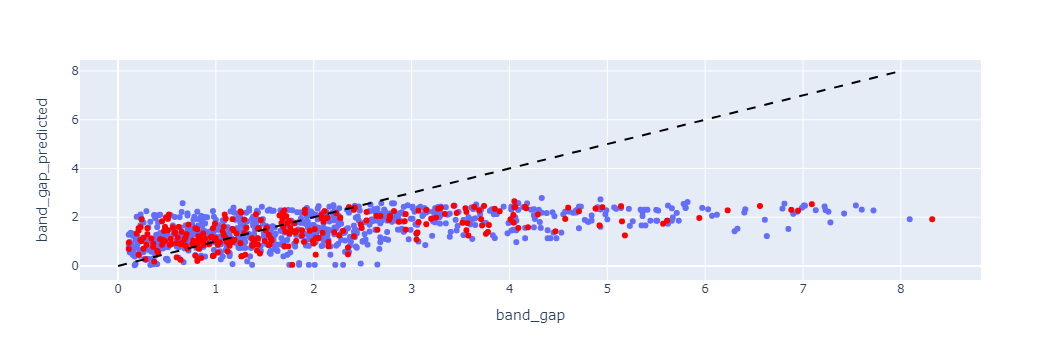

In [102]:
import plotly.express as px
import plotly.graph_objects as go

reference_line = go.Scatter(
    x=[0, 8],
    y=[0, 8],
    line=dict(color="black", dash="dash"),
    mode="lines",
    name="Parity Line",
    showlegend=False,
)

fig = px.scatter(
    df_train,
    x="band_gap",
    y="band_gap_predicted",
    hover_name="formula",
)

fig.add_trace(
    px.scatter(
        df_test,
        x="band_gap",
        y="band_gap_predicted",
        hover_name="formula",
        color_discrete_sequence=["red"],
    ).data[0]
)

fig.add_trace(reference_line)
fig.show()

Not too bad! However, there are definitely some outliers (you can hover over the points with your mouse to see what they are).

### Model interpretation

An important aspect of machine learning is being able to understand why a model is making certain predictions. Random forest models are particularly amenable to interpretation as they possess a `feature_importances` attribute, which contains the importance of each feature in deciding the final prediction. Let's look at the feature importances of our model.

In [96]:
model.coef_

array([-6.27341584e-02, -4.63499808e-02,  1.63841775e-02, -1.12153851e-01,
        1.23367227e-02, -7.19705928e-02,  2.08316051e-02,  4.30148034e-02,
        2.21831984e-02,  4.30167448e-02,  2.45610912e-02,  8.01359177e-03,
        3.20478164e-02,  2.03481147e-02, -1.16997017e-02,  3.04059620e-02,
        1.04386373e-02,  3.20295507e-02, -6.28552343e-04, -5.21021657e-05,
        5.76450177e-04,  1.90937872e-03, -2.97361263e-03, -1.29110578e-03,
        7.03763182e-02,  9.90859078e-02,  2.87095897e-02, -1.23914834e-02,
       -2.67060510e-02, -3.78203723e-02,  8.28276687e-03,  2.14763620e-02,
        1.31935951e-02, -3.38629432e-02,  2.38003951e-03, -5.46662214e-02,
        6.88696874e-03,  2.42322668e-03, -4.46374206e-03, -2.54799806e-02,
        3.46070312e-02,  6.95147259e-03, -1.56315344e-02, -1.85560950e-02,
       -2.92456059e-03, -4.06266551e-03,  5.48985088e-02,  3.12288102e-02,
        1.08842376e-01,  0.00000000e+00, -1.08842376e-01,  1.47711103e-02,
       -2.26088015e-02,  

To make sense of this, we need to know which feature each number corresponds to. We can use `PlotlyFig` to plot the importances of the 5 most important features.

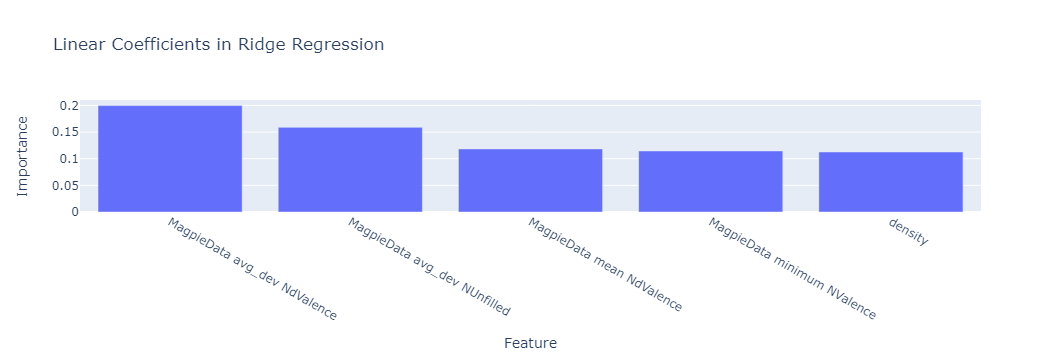

In [97]:
coefficients = np.abs(model.coef_)
included = X_train.columns.values
indices = np.argsort(coefficients)[::-1]

fig_bar = px.bar(
    x=included[indices][0:5],
    y=coefficients[indices][0:5],
    title="Linear Coefficients in Ridge Regression",
    labels={"x": "Feature", "y": "Importance"},
)
fig_bar.show()

## Bonus: Curated ML datasets with Matbench


If you are interested in comparing your machine learning algorithms with the state of the art, matminer also offers access to a curated set of 13 benchmarking datasets called Matbench, which have been used to benchmark SoTA algorithms like RooSt, CGCNN, CRABNet, MEGNet, Automatminer, and more. 

The Matbench datasets span a wide variety of materials informatics tasks such as:

- Predicting materials properties given **only composition**, or given **composition _and_ structure**
- Predicting a **wide array of target properties**, such as elastic constants, dielectric constants, formation energies, and steel yield strength
- **Data-sparse** tasks (300 samples) and (relatively) **data-rich** tasks (100k+ samples)
- Both regression and classification tasks


The full set of datasets is given in the table below:

| Task name | Task type | Target column (unit) | Input type | Samples | MAD (regression) or Fraction True (classification) | Links |
|-------|-------|-------|-------|-------|-------|-------|
| `matbench_steels` | regression | `yield strength` (MPa) | composition | 312 | 229.3743 | [download](https://ml.materialsproject.org/projects/matbench_steels.json.gz), [interactive](https://ml.materialsproject.org/projects/matbench_steels) | 
| `matbench_jdft2d` | regression | `exfoliation_en` (meV/atom) | structure | 636 | 67.2020 | [download](https://ml.materialsproject.org/projects/matbench_jdft2d.json.gz), [interactive](https://ml.materialsproject.org/projects/matbench_jdft2d) | 
| `matbench_phonons` | regression | `last phdos peak` (cm^-1) | structure | 1,265 | 323.7870 | [download](https://ml.materialsproject.org/projects/matbench_phonons.json.gz), [interactive](https://ml.materialsproject.org/projects/matbench_phonons) | 
| `matbench_expt_gap` | regression | `gap expt` (eV) | composition | 4,604 | 1.1432 | [download](https://ml.materialsproject.org/projects/matbench_expt_gap.json.gz), [interactive](https://ml.materialsproject.org/projects/matbench_expt_gap) | 
| `matbench_dielectric` | regression | `n` (unitless) | structure | 4,764 | 0.8085 | [download](https://ml.materialsproject.org/projects/matbench_dielectric.json.gz), [interactive](https://ml.materialsproject.org/projects/matbench_dielectric) | 
| `matbench_expt_is_metal` | classification | `is_metal` | composition | 4,921 | 0.4981 | [download](https://ml.materialsproject.org/projects/matbench_expt_is_metal.json.gz), [interactive](https://ml.materialsproject.org/projects/matbench_expt_is_metal) | 
| `matbench_glass` | classification | `gfa` | composition | 5,680 | 0.7104 | [download](https://ml.materialsproject.org/projects/matbench_glass.json.gz), [interactive](https://ml.materialsproject.org/projects/matbench_glass) | 
| `matbench_log_gvrh` | regression | `log10(G_VRH)` (log10(GPa)) | structure | 10,987 | 0.2931 | [download](https://ml.materialsproject.org/projects/matbench_log_gvrh.json.gz), [interactive](https://ml.materialsproject.org/projects/matbench_log_gvrh) | 
| `matbench_log_kvrh` | regression | `log10(K_VRH)` (log10(GPa)) | structure | 10,987 | 0.2897 | [download](https://ml.materialsproject.org/projects/matbench_log_kvrh.json.gz), [interactive](https://ml.materialsproject.org/projects/matbench_log_kvrh) | 
| `matbench_perovskites` | regression | `e_form` (eV/unit cell) | structure | 18,928 | 0.5660 | [download](https://ml.materialsproject.org/projects/matbench_perovskites.json.gz), [interactive](https://ml.materialsproject.org/projects/matbench_perovskites) | 
| `matbench_mp_gap` | regression | `gap pbe` (eV) | structure | 106,113 | 1.3271 | [download](https://ml.materialsproject.org/projects/matbench_mp_gap.json.gz), [interactive](https://ml.materialsproject.org/projects/matbench_mp_gap) | 
| `matbench_mp_is_metal` | classification | `is_metal` | structure | 106,113 | 0.4349 | [download](https://ml.materialsproject.org/projects/matbench_mp_is_metal.json.gz), [interactive](https://ml.materialsproject.org/projects/matbench_mp_is_metal) |
| `matbench_mp_e_form` | regression | `e_form` (eV/atom) | structure | 132,752 | 1.0059 | [download](https://ml.materialsproject.org/projects/matbench_mp_e_form.json.gz), [interactive](https://ml.materialsproject.org/projects/matbench_mp_e_form) | 



### The Matbench Leaderboard and Benchmarking Code


We host an online benchmark leaderboard - similar to an "ImageNet" for materials science - at the following URL:


### [https://hackingmaterials.lbl.gov/matbench](https://hackingmaterials.lbl.gov/matbench)

Which contains comprehensive data on various SoTA algorithm's performance across tasks in Matbench. On the website you can find:

- **A general purpose leaderboard comparing only the most-widely applicable algorithms**
- **Individual per-task (per-dataset) leaderboards for comparing any ML model on a particular task**
- Comprehensive breakdowns of cross-validation performance, statistics, and metadata for every model
- **Access to individual sample predictions for each and every submission**

![website_mb](resources/website_mb.png)



### General purpose leaderboard

| Task name | Samples | Algorithm | Verified MAE (unit) or ROCAUC | Notes |
|------------------|---------|-----------|----------------------|-------|
| matbench_steels | 312 | [AMMExpress v2020](https://hackingmaterials.github.io/matbench/Full%20Benchmark%20Data/matbench_v0.1_automatminer_expressv2020) | **97.4929 (MPa)** |  |
| matbench_jdft2d | 636 | [AMMExpress v2020](https://hackingmaterials.github.io/matbench/Full%20Benchmark%20Data/matbench_v0.1_automatminer_expressv2020) | **39.8497 (meV/atom)** |  |
| matbench_phonons | 1,265 | [CrabNet](https://hackingmaterials.github.io/matbench/Full%20Benchmark%20Data/matbench_v0.1_CrabNet) | **55.1114 (cm^-1)** |  |
| matbench_expt_gap | 4,604 | [CrabNet](https://hackingmaterials.github.io/matbench/Full%20Benchmark%20Data/matbench_v0.1_CrabNet) | **0.3463 (eV)** |  |
| matbench_dielectric | 4,764 | [AMMExpress v2020](https://hackingmaterials.github.io/matbench/Full%20Benchmark%20Data/matbench_v0.1_automatminer_expressv2020) | **0.3150 (unitless)** |  |
| matbench_expt_is_metal | 4,921 | [AMMExpress v2020](https://hackingmaterials.github.io/matbench/Full%20Benchmark%20Data/matbench_v0.1_automatminer_expressv2020) | **0.9209** |  |
| matbench_glass | 5,680 | [AMMExpress v2020](https://hackingmaterials.github.io/matbench/Full%20Benchmark%20Data/matbench_v0.1_automatminer_expressv2020) | **0.8607** |  |
| matbench_log_gvrh | 10,987 | [AMMExpress v2020](https://hackingmaterials.github.io/matbench/Full%20Benchmark%20Data/matbench_v0.1_automatminer_expressv2020) | **0.0874 (log10(GPa))** |  |
| matbench_log_kvrh | 10,987 | [AMMExpress v2020](https://hackingmaterials.github.io/matbench/Full%20Benchmark%20Data/matbench_v0.1_automatminer_expressv2020) | **0.0647 (log10(GPa))** |  |
| matbench_perovskites | 18,928 | [CGCNN v2019](https://hackingmaterials.github.io/matbench/Full%20Benchmark%20Data/matbench_v0.1_cgcnnv2019) | **0.0452 (eV/unit cell)** | structure required |
| matbench_mp_gap | 106,113 | [CrabNet](https://hackingmaterials.github.io/matbench/Full%20Benchmark%20Data/matbench_v0.1_CrabNet) | **0.2655 (eV)** |  |
| matbench_mp_is_metal | 106,113 | [CGCNN v2019](https://hackingmaterials.github.io/matbench/Full%20Benchmark%20Data/matbench_v0.1_cgcnnv2019) | **0.9520** | structure required |
| matbench_mp_e_form | 132,752 | [CGCNN v2019](https://hackingmaterials.github.io/matbench/Full%20Benchmark%20Data/matbench_v0.1_cgcnnv2019) | **0.0337 (eV/atom)** | structure required |
